# London Borough of Barnet
## Analysis of Credit Card Transactions, 2014-16
### Prepared by David Modjeska, 28 November 2016

In [100]:
import datetime
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from collections import Counter
from scipy.stats import norm
from sklearn.cluster import KMeans

from IPython.display import display, HTML
plt.style.use('ggplot') 
%matplotlib inline

## Table of Contents

&nbsp;&nbsp;&nbsp;&nbsp;[Executive Summary](#exec_sum)
2. [The Data](#data)
3. [Summary Graphs and Tables](#sum_vis) 
4. [Significant Changes in Spending Behavior](#changes)
5. [Classifying Creditors to Accounts](#classification)
6. [Grouping Service Areas](#groups)
7. [Anomaly Detection](#anomalies)

<a id="exec_sum"></a>

## Executive Summary

In response to a request from an auditor, we reviewed corporate credit card transactions for the London borough of Barnet for the period 2014-2016. We performed several kinds of analysis: summary, trend analysis, classification review, clustering, and anomaly identification. Data quality was reasonble, so we were able to fulfill all of the analysis requests. The rest of this report will review the analysis in detail. The analysis requests and key findings are summarized below.

#### Analysis Requests
1. Quarterly summary charts and tables for each service area, including transaction counts and averages.
2. Significant changes in spending behvior by service area and by account, including both spikes and permanent changes.
3. Identification of inconsistent creditor classification to accounts.
4. Grouping service areas by spending behavior, specifically transaction count and average transaction amount.
5. Identification of several hundred anomalous or unusual transactions, including at least five transactions from each service area.

#### Key Findings
* 75% of creditors are classified consistently, but 25% are classified inconsistently.
* 16 spikes occurred in quarterly spending by the 23 service areas, as well as 42 such spikes for the 64 accounts.
* 13 permanent increases occurred in quarterly spending by service area, as well as 25 such increases by account.
* Service areas cluster naturally into four groups, on the basis of transaction count and average transaction amount.
* Approximately 330 or 3.5% of transactions are anomalous for high transaction amounts (above the 98th percentile for their service areas)
* Approximately 90 or 0.9% of transactions are anomalous as one-time charges to an account within a given service area (which might represent misconduct or misclassification)

-----
<a id="data"></a>

## 1.  The Data

The data that we analyzed consists of approximately 10,000 records from the period 2014-16, representing credit card transactions for the London borough of Barnet. Each record in the data contains several fields: service area, account, creditor, journal date, journal reference, and total (i.e., transaction amount). We obtained the data in three separate files, which were concatenated together for this analysis. As part of data cleaning, approximately 4% of the data records were removed as duplicates. Extracts from the data files are shown below. 

By way of summary, the data lists 23 service areas, 64 accounts, and 1600 creditors. The first transaction occurred on 2 April 2014, and the last on 2 September 2016. The smallest transaction was a credit of £4707, and the largest a debit of £15,341. Further summary information is below.

In [101]:
# from https://data.gov.uk/dataset/corporate-credit-card-transaction-2014-15
data_2014 = pd.read_csv("Purchasing Card Data 2014.csv", nrows = 4562, thousands=',',
                        parse_dates = False)

# from https://data.gov.uk/dataset/corporate-credit-card-transactions-2015-16
data_2015 = pd.read_csv("PCard Transactions 15-16.csv", nrows = 3864, thousands=',',
                        parse_dates = False)

# from https://data.gov.uk/dataset/corporate-credit-card-transaction-2016-17
data_2016 = pd.read_csv("PCard 16-17.csv", nrows = 1604, thousands=',',
                        parse_dates = False)

In [102]:
data_2014 = data_2014.drop('JV Date', axis = 1)

columns = ['Service Area', 'Account', 'Creditor', 'Journal Date', 'Journal Reference', 'Total']
data_2014.columns = columns
data_2015.columns = columns
data_2016.columns = columns

#### First Rows of 2014 Data

In [103]:
display(data_2014.head(3))

,Service Area,Account,Creditor,Journal Date,Journal Reference,Total
0,Childrens Services,IT Services,123-REG.CO.UK,23/04/2014,93,143.81
1,Childrens Services,Other Services,ACCESS EXPEDITIONS,03/04/2014,111,"6,000.00"
2,Childrens Services,Equipment and Materials Repair,AFE SERVICELINE,02/04/2014,6,309.38


#### First Rows of 2015 Data

In [104]:
display(data_2015.head(3))

,Service Area,Account,Creditor,Journal Date,Journal Reference,Total
0,Assurance,Miscellaneous Expenses,43033820 COSTA COFFEE,18/08/2015,5043,2.00
1,Children's Family Services,Miscellaneous Expenses,99 PLUS DISCOUNT MART,08/06/2015,4184,29.97
2,Children's Family Services,E19 - Learning Resources,99P STORES LTD,07/12/2015,6278,34.65


#### First Rows of 2016 Data

In [105]:
display(data_2016.head(3))

,Service Area,Account,Creditor,Journal Date,Journal Reference,Total
0,Assurance,Travelling Expenses,TICKETOFFICESALE,04/03/2016,7331,29.10
1,Assurance,Travelling Expenses,SELFSERVE TICKET,07/03/2016,7342,10.00
2,Assurance,Miscellaneous Expenses,BIRMINGHAM CC,22/04/2016,7871,69.00


In [106]:
# concatenate 3 data files and remove duplicates
data = pd.concat((data_2014, data_2015, data_2016), axis = 0).reset_index(drop = True)
data = data.drop_duplicates()

#### Comments on Data

In [107]:
n, p = data.shape
print "The data has " + '{:,.0f}'.format(n) + " rows and " + str(p) + " columns."

The data has 9,610 rows and 6 columns.


In [108]:
### check for nulls
print "Verification: the number of nulls in the data set is", data.isnull().sum().sum()

Verification: the number of nulls in the data set is 0


In [109]:
# convert date strings to datetime and create quarters column
data['Quarter'] = ""
for index in range(data.shape[0]):
    data['Journal Date'].values[index] = \
        datetime.datetime.strptime(data['Journal Date'].values[index], "%d/%m/%Y")
    data['Quarter'].values[index] = str(data['Journal Date'].values[index].year) + " Q" + \
        str(((data['Journal Date'].values[index].month - 1) // 3) + 1)

In [110]:
# clean data
data['Service Area'] = data['Service Area'].str.replace("Streetscene", "Street Scene")
data['Creditor'] = data['Creditor'].str.title()
data['Journal Reference'] = data['Journal Reference'].astype(str) # for display only

#### Complete List of Service Areas

In [111]:
service_areas = np.unique(data['Service Area'])
num_service_areas = len(service_areas)
print ', '.join(service_areas)

Adults and Communities, Assurance, CSG Managed Budget, Children's Education & Skills, Children's Family Services, Children's Service DSG, Childrens Services, Commercial, Commissioning, Control Accounts, Corporate Accounting, Customer Support Group, Deputy Chief Operating Officer, Education, Family Services, Governance, Internal Audit & CAFT, NSCSO, Parking & Infrastructure, Public Health, Regional Enterprise, Strategic Commissioning Board, Street Scene


#### Complete List of Accounts

In [112]:
accounts = np.unique(data['Account'])
num_accounts = len(accounts)
print ', '.join(accounts)

Advertising, Advertising for staff, Books-CDs-Audio-Video, Building Repairs & Maintenance, Catering Recharge, Cleaning and domestic material, Clothing - Protective Clothing, Clothing - Uniforms, Conference Expenses, Consultants Fees, Consumable Catering Supplies, Counsels Fees, E19 - Learning Resources, E25 - Catering Supplies, Education CFR Administrative S, Education CFR Other Occupation, Electricity, Employer's National Insurance , Equipment Hire, Equipment and Materials Purcha, Equipment and Materials Repair, Fees and Charges, Fixtures and fittings, Food Costs, Furniture-Purchase-Repair, Gas, General Office Expenses, Grant Payments, Grounds maintenance, Hardware Purchases, IT Services, Laundry and Dry Cleaning, Legal and Court Fees, Miscellaneous Expenses, NNDR Collected, Non Education Staff GPay, Operating Leases - Transport, Other Agencies - Third Party P, Other Energy, Other Establishments - Third P, Other Indirect Employee Expens, Other Services, Other Transfer Payments to Soc,

#### Summary of Transaction Amounts

In [113]:
display(pd.DataFrame(data['Total'].describe()))

,Total
count,"9,610.00"
mean,100.65
std,411.47
min,"-4,707.00"
25%,10.00
50%,25.58
75%,90.00
max,"15,340.80"


#### Summary of Other Data

In [114]:
creditors = np.unique(data['Creditor'])
num_creditors = len(creditors)
print
print "\tNumber of creditors = ", num_creditors


	Number of creditors =  1600


In [115]:
print
print "\tJournal Dates"
print
print "\t\tEarliest =", min(data['Journal Date'].values).strftime('%Y-%b-%d')
print "\t\tLatest =", max(data['Journal Date'].values).strftime('%Y-%b-%d')


	Journal Dates

		Earliest = 2014-Apr-02
		Latest = 2016-Sep-02


In [116]:
quarters = np.unique(data['Quarter'])
num_quarters = len(quarters)
print
print "\tNumber of quarters =", num_quarters


	Number of quarters = 10


-----
<a id="sum_vis"></a>

## 2. Summary Graphs and Tables

In response to the auditor's request, we provide a series of summary graphs and tables below. 

Three sets of summary graphs are provided for the borough transactions - one each for counts, sums, and averages. Each series include a graph for each service area, as well as an overall graph. The overall graphs show moderately consistent spending levels, while the graphs for individual service areas vary widely. For example, spending for Adults and Communities trends roughly with the overall graph, while spending for Public Health occurs in one quarter only. 

We also include four summary tables, to support the graphs with quantitative information.

In [117]:
### create grouped summary table for all aggregates

pd.options.display.float_format = '{:,.0f}'.format
pd.set_option('display.max_rows', num_service_areas * num_quarters)

data_qtr = data.groupby(('Service Area', 'Quarter'))
summary = data_qtr[['Total']].agg((np.count_nonzero, np.sum, np.mean))

summary.columns = summary.columns.set_levels(['Transactions'], level = 0)
summary.columns = summary.columns.set_levels(['Count', 'Sum (£)', 'Average (£)'], level = 1)

In [118]:
# function to create a pivot table for one aggregate
def create_qtr_agg_table_overall(agg_func):
    aggs = np.zeros(num_quarters)
    for qtr in range(num_quarters):
        aggs[qtr] = agg_func(data[data['Quarter'] == quarters[qtr]]['Total'])
    aggs[np.isnan(aggs) == True] = 0.0
    aggs_df = pd.DataFrame(aggs.reshape(-1, 1))
    aggs_df.index = quarters

    return aggs_df

In [119]:
# function to create a pivot table for one aggregate
def create_qtr_agg_table(agg_func):
    aggs = np.zeros((num_service_areas, num_quarters))
    for area in range(num_service_areas):
        for qtr in range(num_quarters):
            aggs[area, qtr] = agg_func(data[(data['Service Area'] == service_areas[area]) & \
                                    (data['Quarter'] == quarters[qtr])]['Total'])
    aggs[np.isnan(aggs) == True] = 0.0
    aggs_df = pd.DataFrame(aggs)
    aggs_df.columns = quarters
    aggs_df.index = service_areas

    return aggs_df

In [120]:
### create aggregate tables

area_counts_qtr_overall = create_qtr_agg_table_overall(np.count_nonzero)
area_sums_qtr_overall = create_qtr_agg_table_overall(np.sum)
area_means_qtr_overall = create_qtr_agg_table_overall(np.mean)

area_counts_qtr = create_qtr_agg_table(np.count_nonzero)
area_sums_qtr = create_qtr_agg_table(np.sum)
area_means_qtr = create_qtr_agg_table(np.mean)

area_counts = area_counts_qtr.sum(axis = 1).reshape(-1, 1).astype(int)
area_means = area_sums_qtr.sum(axis = 1).reshape(-1, 1).astype(float) / area_counts

In [121]:
def do_one_subplot(ax, heights, color, agg_name, title):
    
    # set bar indexes and width
    ind = np.arange(num_quarters)  
    width = 0.35 

    # create subplot
    ax.bar(ind, heights, width, color = color)
    ax.set_xticks(ind + (width/2))
    ax.set_xticklabels(quarters)
    ax.set_xlim(-0.5, num_quarters)

    # label subplot
    ax.set_xlabel("Quarter")
    ax.set_ylabel(agg_name)
    ax.set_title(title)

In [122]:
def plot_transactions_overall(table, agg_name, color = 'darkblue'):

    # allocate subplots
    fig = plt.figure(figsize = (9, 2))
    ax = fig.add_subplot(1, 1, 1)
        
    do_one_subplot(ax, table[0], color, agg_name, "All Service Areas".upper())

    # show plot
    plt.show()

In [123]:
def plot_transactions(table, agg_name, color = 'darkblue'):

    # allocate subplots
    fig, ax_ar = plt.subplots(num_service_areas, 1, figsize = (8, 48))

    # create all subplots
    for index in range(num_service_areas):
        do_one_subplot(ax_ar[index], table.iloc[index, :], color, agg_name, service_areas[index])

    # show plot
    plt.tight_layout()
    plt.show()

### Transaction Counts by Quarter

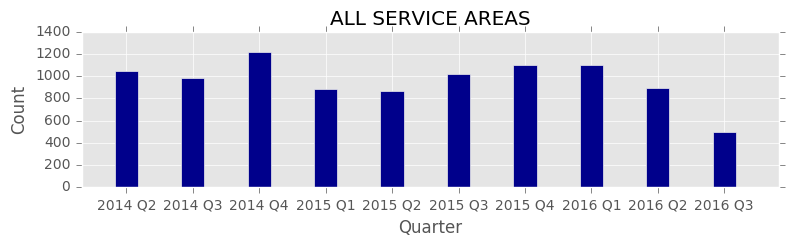

In [124]:
plot_transactions_overall(area_counts_qtr_overall, "Count", 'darkblue')

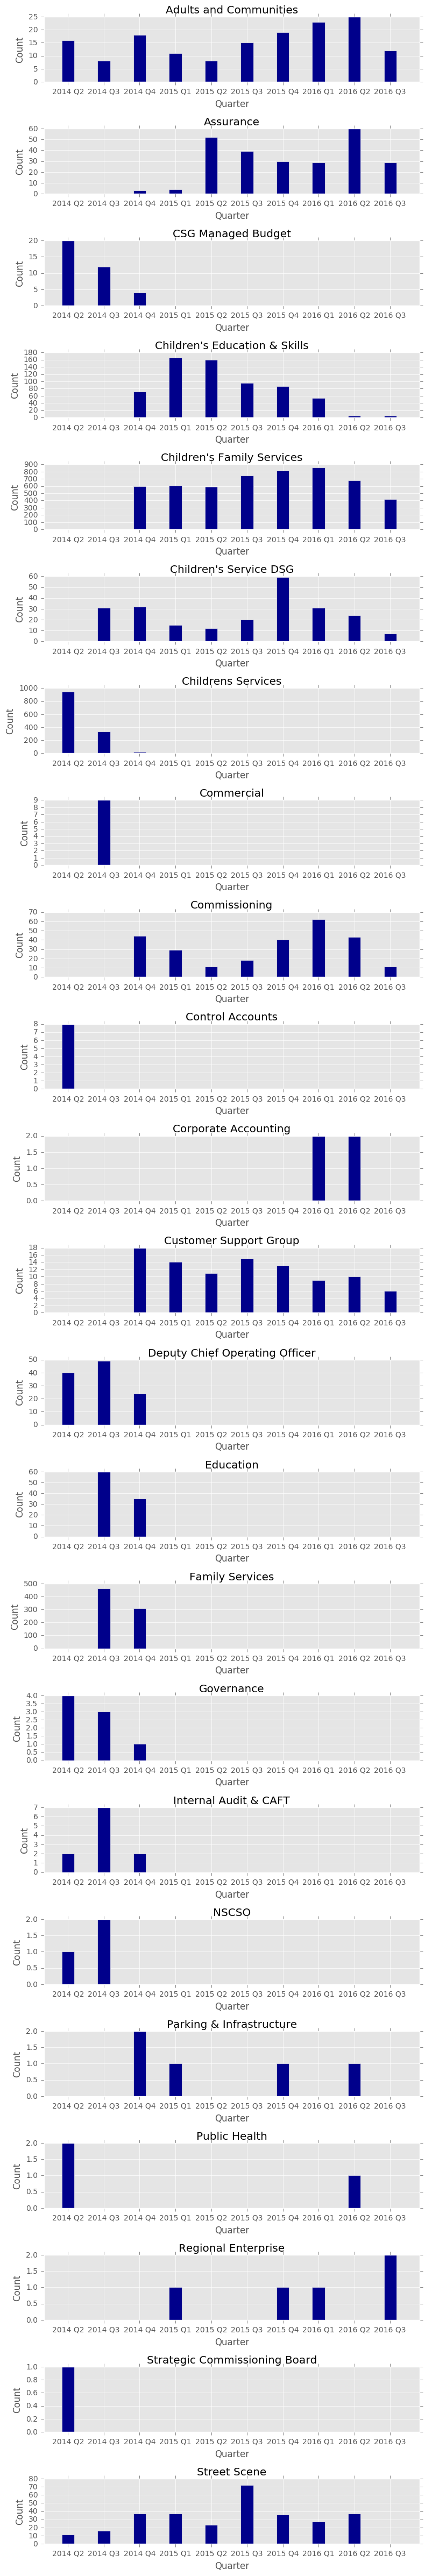

In [125]:
plot_transactions(area_counts_qtr, "Count", 'darkblue')

### Transaction Sums by Quarter (£)

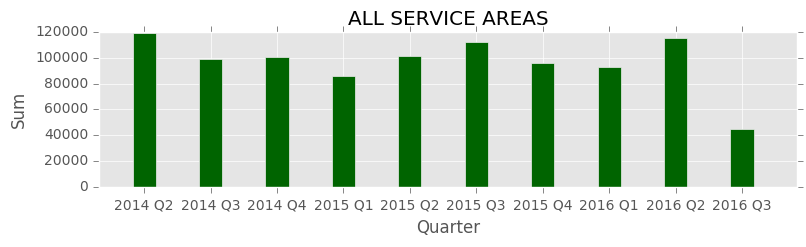

In [126]:
plot_transactions_overall(area_sums_qtr_overall, "Sum", 'darkgreen')

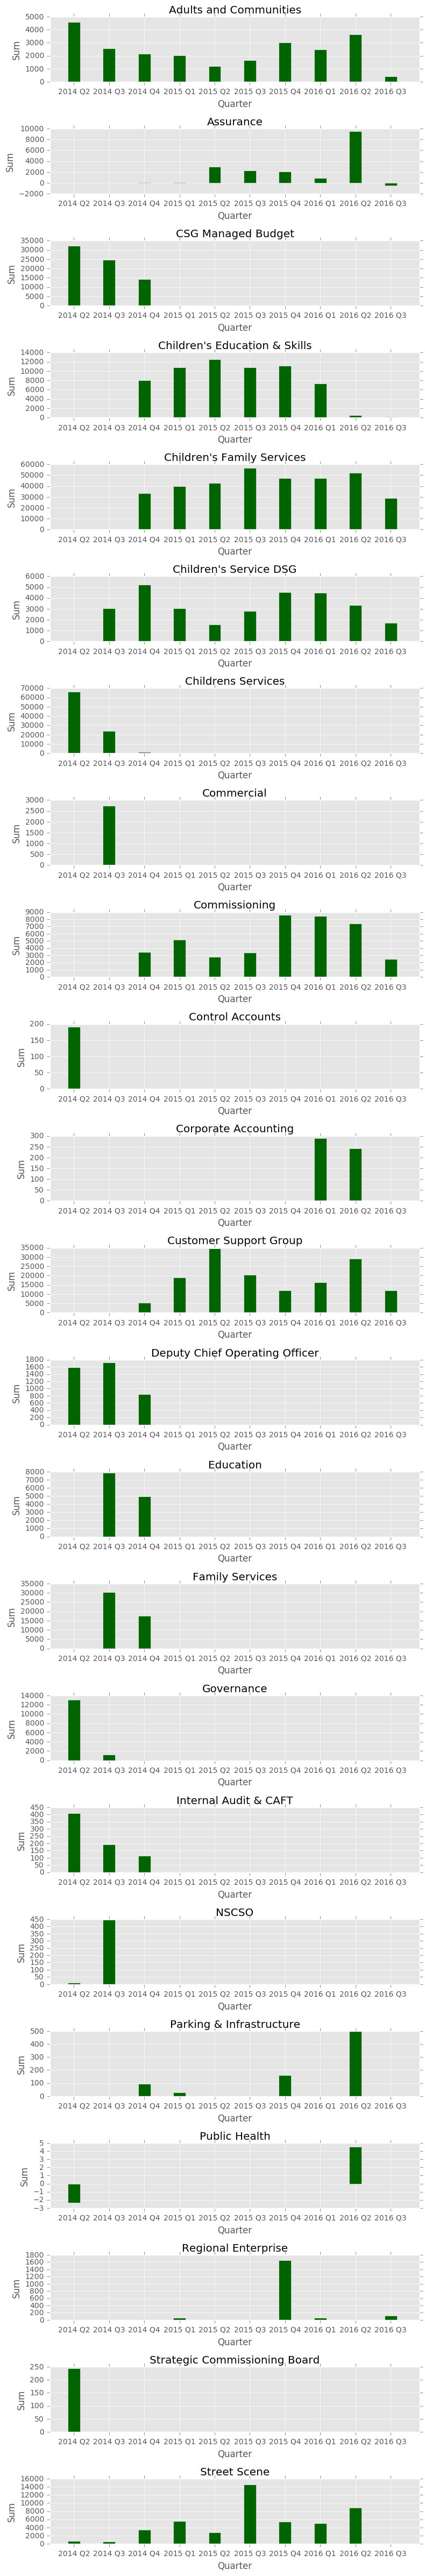

In [127]:
plot_transactions(area_sums_qtr, "Sum", 'darkgreen')

### Transaction Averages by Quarter (£)

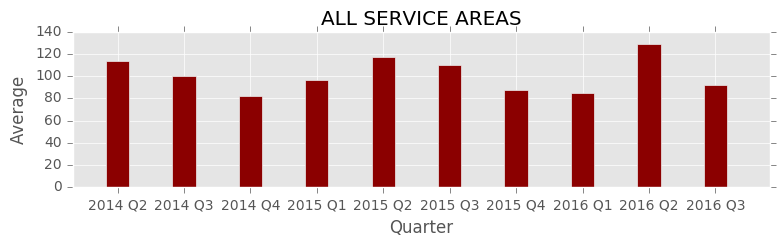

In [128]:
plot_transactions_overall(area_means_qtr_overall, "Average", 'darkred')

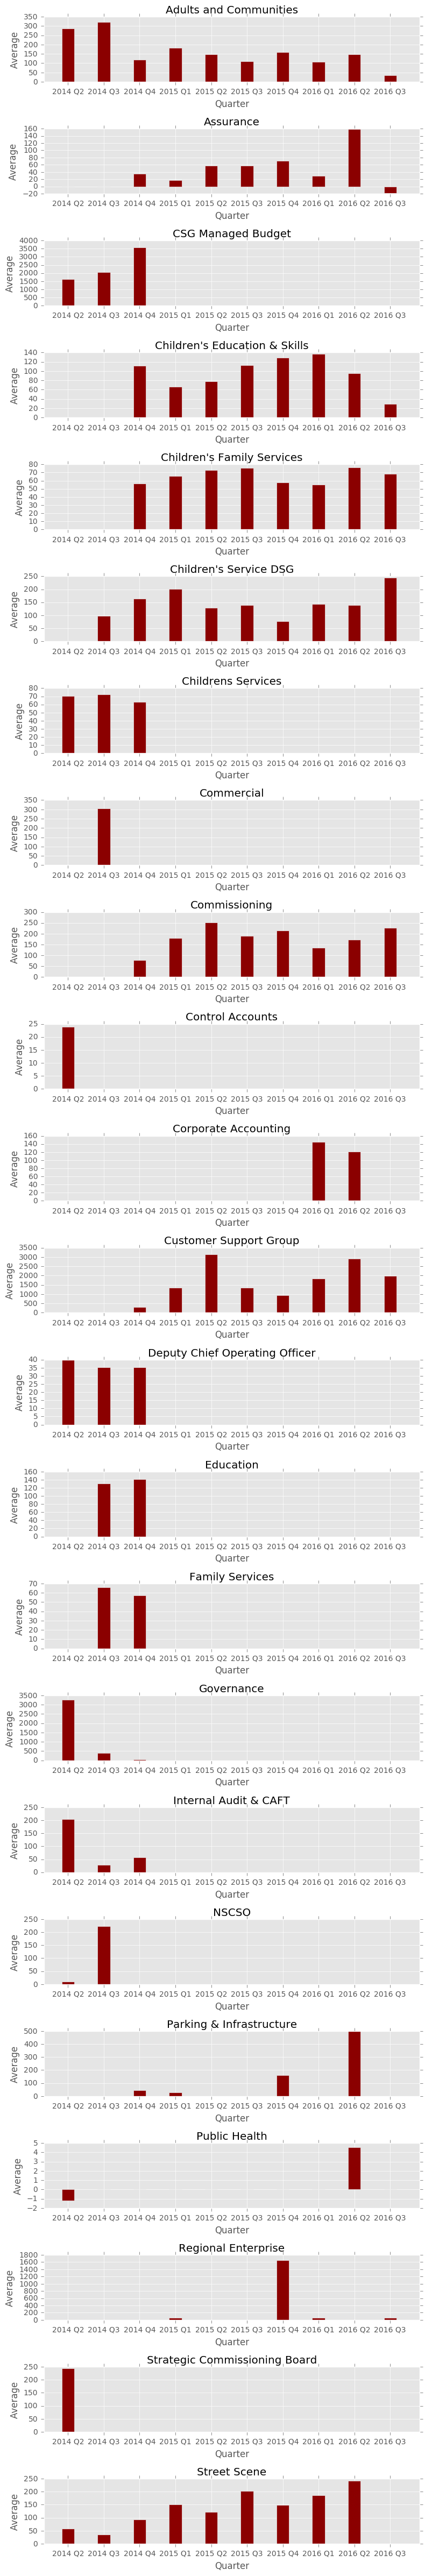

In [129]:
plot_transactions(area_means_qtr, "Average", 'darkred')

### Summary Tables

We also provide four summary tables, to support the graphs with quantitative information. The first table is a hierarchical breakdown of quarterly spending by service area, listing only active quarters for each service area. This table includes all three aggregates - counts, sums, and averages. The next three tables cover the three aggregates, broken down by service area and quarter. (The hierarchical table is useful for focusing on specific service areas; the grid tables are useful for focusing on trends over time.)

#### Transaction Summary (by Service Area)

In [130]:
display(summary)

Transactions                    
                                              Count Sum (£) Average (£)
Service Area                   Quarter                                 
Adults and Communities         2014 Q2           16   4,608         288
                               2014 Q3            8   2,570         321
                               2014 Q4           18   2,149         119
                               2015 Q1           11   2,018         183
                               2015 Q2            8   1,187         148
                               2015 Q3           15   1,636         109
                               2015 Q4           19   3,039         160
                               2016 Q1           23   2,469         107
                               2016 Q2           25   3,659         146
                               2016 Q3           12     414          35
Assurance                      2014 Q4            3     105          35
                               2015 Q1            4      67          17
                               2015 Q2           52   2,962          57
                               2015 Q3           39   2,262          58
                               2015 Q4           30   2,110          70
                               2016 Q1           29     849          29
                               2016 Q2           60   9,510         159
                               2016 Q3           29    -533         -18
CSG Managed Budget             2014 Q2           20  32,167       1,608
                               2014 Q3           12  24,549       2,046
                               2014 Q4            4  14,270       3,568
Children's Education & Skills  2014 Q4           72   8,036         112
                               2015 Q1          165  10,836          66
                               2015 Q2          160  12,525          78
                               2015 Q3           96  10,778         112
                               2015 Q4           86  11,116         129
                               2016 Q1           54   7,368         136
                               2016 Q2            5     476          95
                               2016 Q3            4     118          30
Children's Family Services     2014 Q4          597  33,509          56
                               2015 Q1          607  39,859          66
                               2015 Q2          588  42,989          73
                               2015 Q3          748  56,548          76
                               2015 Q4          814  47,278          58
                               2016 Q1          859  47,483          55
                               2016 Q2          682  52,034          76
                               2016 Q3          422  28,907          68
Children's Service DSG         2014 Q3           31   3,048          98
                               2014 Q4           32   5,214         163
                               2015 Q1           15   3,031         202
                               2015 Q2           12   1,543         129
                               2015 Q3           20   2,776         139
                               2015 Q4           59   4,531          77
                               2016 Q1           31   4,457         144
                               2016 Q2           24   3,343         139
                               2016 Q3            7   1,716         245
Childrens Services             2014 Q2          946  66,339          70
                               2014 Q3          331  23,999          73
                               2014 Q4           20   1,264          63
Commercial                     2014 Q3            9   2,743         305
Commissioning                  2014 Q4           44   3,425          78
                               2015 Q1           29   5,189         179
                               2015 Q2           11   2,776         252
       

#### Transaction Counts (by Service Area and Quarter)

In [131]:
display(area_counts_qtr)

,2014 Q2,2014 Q3,2014 Q4,2015 Q1,2015 Q2,2015 Q3,2015 Q4,2016 Q1,2016 Q2,2016 Q3
Adults and Communities,16,8,18,11,8,15,19,23,25,12
Assurance,0,0,3,4,52,39,30,29,60,29
CSG Managed Budget,20,12,4,0,0,0,0,0,0,0
Children's Education & Skills,0,0,72,165,160,96,86,54,5,4
Children's Family Services,0,0,597,607,588,748,814,859,682,422
Children's Service DSG,0,31,32,15,12,20,59,31,24,7
Childrens Services,946,331,20,0,0,0,0,0,0,0
Commercial,0,9,0,0,0,0,0,0,0,0
Commissioning,0,0,44,29,11,18,40,62,43,11
Control Accounts,8,0,0,0,0,0,0,0,0,0


#### Transaction Sums (by Service Area and Quarter)

In [132]:
display(area_sums_qtr)

,2014 Q2,2014 Q3,2014 Q4,2015 Q1,2015 Q2,2015 Q3,2015 Q4,2016 Q1,2016 Q2,2016 Q3
Adults and Communities,"4,608","2,570","2,149","2,018","1,187","1,636","3,039","2,469","3,659",414
Assurance,0,0,105,67,"2,962","2,262","2,110",849,"9,510",-533
CSG Managed Budget,"32,167","24,549","14,270",0,0,0,0,0,0,0
Children's Education & Skills,0,0,"8,036","10,836","12,525","10,778","11,116","7,368",476,118
Children's Family Services,0,0,"33,509","39,859","42,989","56,548","47,278","47,483","52,034","28,907"
Children's Service DSG,0,"3,048","5,214","3,031","1,543","2,776","4,531","4,457","3,343","1,716"
Childrens Services,"66,339","23,999","1,264",0,0,0,0,0,0,0
Commercial,0,"2,743",0,0,0,0,0,0,0,0
Commissioning,0,0,"3,425","5,189","2,776","3,402","8,603","8,435","7,370","2,486"
Control Accounts,191,0,0,0,0,0,0,0,0,0


#### Transaction Averages (by Service Area and Quarter)

In [133]:
display(area_means_qtr)

,2014 Q2,2014 Q3,2014 Q4,2015 Q1,2015 Q2,2015 Q3,2015 Q4,2016 Q1,2016 Q2,2016 Q3
Adults and Communities,288,321,119,183,148,109,160,107,146,35
Assurance,0,0,35,17,57,58,70,29,159,-18
CSG Managed Budget,"1,608","2,046","3,568",0,0,0,0,0,0,0
Children's Education & Skills,0,0,112,66,78,112,129,136,95,30
Children's Family Services,0,0,56,66,73,76,58,55,76,68
Children's Service DSG,0,98,163,202,129,139,77,144,139,245
Childrens Services,70,73,63,0,0,0,0,0,0,0
Commercial,0,305,0,0,0,0,0,0,0,0
Commissioning,0,0,78,179,252,189,215,136,171,226
Control Accounts,24,0,0,0,0,0,0,0,0,0


-----
<a id="changes"></a>

## 3. Significant Changes in Spending Behavior

In looking over the graphs and tables above, it's clear that there are many changes in spending level. We investigated how many of these changes were temporary or permanent.

First we examined temporary spikes in spending behavior. We did this for each service area and account separately. Although moving averages are useful in many situations, the intermittent quarterly spending in this dataset required a different approach. We calculated the average quarterly transaction sum for each service area and account, as well as the standard deviation. Then we simply flagged those transactions that were at the high end of each bell curve. To retrieve a manageable number of transactions, we set a threshold at the top 2% of transactions within each service area or account. 

To retrieve more transactions for consideration as possible anomalies, we could potentially increase the threshold above 2%. To retrieve fewer transactions, we could decrease this threshold.

Results below show 16 quarterly spikes in transaction amounts among the service areas. The listed spikes correspond to unusually tall bars in the summary graphs below, which helps to confirm the results. Results also show 42 spikes among the accounts. Since there are approximately three times as many accounts as service areas, this approximate ratio of 3 to 1 in spikes is reasonable.

### Spikes

In [134]:
# calculate account sums by quarter
account_sums_qtr = np.zeros((num_accounts, num_quarters))
for account in range(num_accounts):
    for qtr in range(num_quarters):
        account_sums_qtr[account, qtr] = np.sum(data[(data['Account'] == accounts[account]) & \
                                (data['Quarter'] == quarters[qtr])]['Total'])

In [135]:
### calculate quarterly means and variances

area_sum_qtr_means = area_sums_qtr.mean(axis = 1).reshape(-1, 1)  
area_sum_qtr_vars = area_sums_qtr.var(axis = 1).reshape(-1, 1)  

account_sum_qtr_means = account_sums_qtr.mean(axis = 1).reshape(-1, 1)  
account_sum_qtr_vars = account_sums_qtr.var(axis = 1).reshape(-1, 1)  

#### Service Areas

In [136]:
### calculate quarterly spikes in service areas

pd.options.display.float_format = '{:,.2f}'.format
spikes = []

for index in range(num_service_areas):
    for qtr in range(num_quarters):
        z_score = float((area_sums_qtr.iloc[index, qtr] - area_sum_qtr_means[index]) \
                    / np.power(area_sum_qtr_vars[index], 0.5))
        if z_score > 2:
            spikes.append((service_areas[index], quarters[qtr], area_sums_qtr.iloc[index, qtr], z_score))

spikes_df = pd.DataFrame(spikes, columns = ['Service Area', 'Quarter', 'Transaction Sum', 'SDs from Average'])
display(spikes_df.sort_values(by = 'SDs from Average', ascending = False).reset_index(drop = True))

,Service Area,Quarter,Transaction Sum,SDs from Average
0,Strategic Commissioning Board,2014 Q2,244.00,2.85
1,Control Accounts,2014 Q2,190.71,2.85
2,Commercial,2014 Q3,"2,743.05",2.85
3,NSCSO,2014 Q3,445.50,2.85
4,Regional Enterprise,2015 Q4,"1,645.00",2.84
5,Governance,2014 Q2,"13,011.60",2.83
6,Parking & Infrastructure,2016 Q2,500.00,2.67
7,Childrens Services,2014 Q2,"66,339.06",2.67
8,Assurance,2016 Q2,"9,510.24",2.61
9,Public Health,2016 Q2,4.55,2.56


#### Accounts

In [137]:
### calculate quarterly spikes in accounts

pd.options.display.float_format = '{:,.2f}'.format
spikes = []

for index in range(num_accounts):
    for qtr in range(num_quarters):
        z_score = float((account_sums_qtr[index, qtr] - account_sum_qtr_means[index]) \
                    / np.power(account_sum_qtr_vars[index], 0.5))
        if z_score > 2.0:
            spikes.append((accounts[index], quarters[qtr], account_sums_qtr[index, qtr], z_score))

spikes_df = pd.DataFrame(spikes, columns = ['Account', 'Quarter', 'Transaction Sum', 'SDs from Average'])
display(spikes_df.sort_values(by = 'SDs from Average', ascending = False).reset_index(drop = True))

,Account,Quarter,Transaction Sum,SDs from Average
0,Operating Leases - Transport,2016 Q1,65.83,3.00
1,Catering Recharge,2016 Q1,100.00,3.00
2,Clothing - Uniforms,2014 Q3,107.50,3.00
3,Non Education Staff GPay,2016 Q2,115.80,3.00
4,Advertising for staff,2016 Q2,450.00,3.00
5,Grant Payments,2015 Q3,660.00,3.00
6,Counsels Fees,2016 Q1,"1,200.00",3.00
7,Gas,2016 Q2,"1,695.22",3.00
8,NNDR Collected,2016 Q2,4.10,3.00
9,Employer's National Insurance,2015 Q4,6.67,3.00


### Permanent Changes

To find permanent changes in spending behavior, we used another technique. Using the quarterly sums and standard deviations calculated above, we found each quarter where the cumulative average up to that quarter was at one level, and the cumulative average after that quarter was at a higher level. We set the threshold in level increase to be 1 standard deviation. 

To retrieve more quarters with permanent changes in spending behavior, we could potentially decrease the threshold below 1 standard deviation. To retrieve fewer quarters, we could increase this threshold.

Results below show 13 permanent increases in spending by service areas. We verified in the summary graphs above that bar height increased after the quarters listed below. Results also show 25 permanent increases in spending in accounts.

#### Service Areas

In [138]:
# find permanent changes in spending by service areas
changes = []
for area in range(num_service_areas):
    for qtr in range(1, num_quarters - 1):
        before_mean = area_sums_qtr.iloc[area, :(qtr + 1)].mean()
        after_mean = area_sums_qtr.iloc[area, (qtr + 1):].mean()
        var = area_sums_qtr.iloc[area, 1:].var()
        means_diff = after_mean - before_mean
        z_score = means_diff / np.power(var, 0.5)
        
        # flag positive changes where long_term averages increase by more than 1 SD
        if (z_score > 1) and (area_sums_qtr.iloc[area, qtr] < area_sums_qtr.iloc[area, (qtr + 1)]):
            changes.append((service_areas[area], quarters[qtr + 1], before_mean, after_mean, z_score))
            
changes_df = pd.DataFrame(changes, columns = ['Service Area', 'After Quarter', 'Old Average', \
                                             'New Average', 'SDs Change'])
changes_df = changes_df[changes_df['Old Average'] > 0]
display(changes_df.reset_index(drop = True))

,Service Area,After Quarter,Old Average,New Average,SDs Change
0,Assurance,2016 Q2,"1,044.56","4,488.68",1.11
1,Children's Family Services,2015 Q1,"11,169.57","45,013.86",2.00
2,Children's Family Services,2015 Q2,"18,341.83","45,873.07",1.63
3,Children's Family Services,2015 Q3,"23,271.26","46,449.88",1.37
4,Children's Service DSG,2014 Q4,"1,523.87","3,326.34",1.44
5,Commissioning,2015 Q1,"1,141.80","5,465.83",1.46
6,Commissioning,2015 Q3,"2,278.23","6,059.01",1.27
7,Commissioning,2015 Q4,"2,465.50","6,723.30",1.43
8,Customer Support Group,2015 Q1,"1,791.77","20,473.54",1.72
9,Customer Support Group,2015 Q2,"6,069.07","20,735.63",1.35


#### Accounts

In [139]:
# find permanent changes in spending by accounts
changes = []
for account in range(num_accounts):
    for qtr in range(1, num_quarters - 1):
        before_mean = account_sums_qtr[account, :(qtr + 1)].mean()
        after_mean = account_sums_qtr[account, (qtr + 1):].mean()
        var = account_sums_qtr[account, 1:].var()
        means_diff = after_mean - before_mean
        z_score = means_diff / np.power(var, 0.5)
        
        # flag positive changes where long_term averages increase by more than 1 SD
        if (z_score > 1) and (area_sums_qtr.iloc[area, qtr] < area_sums_qtr.iloc[area, (qtr + 1)]):
            changes.append((accounts[account], quarters[qtr + 1], before_mean, after_mean, z_score))
            
changes_df = pd.DataFrame(changes, columns = ['Account', 'Starting Quarter', 'Old Average', \
                                             'New Average', 'SDs Change'])
changes_df = changes_df[changes_df['New Average'] > 0]
display(changes_df.reset_index(drop = True))

,Account,Starting Quarter,Old Average,New Average,SDs Change
0,Advertising for staff,2016 Q2,0.00,225.00,1.59
1,Conference Expenses,2015 Q3,259.36,"1,092.46",1.08
2,Consultants Fees,2016 Q2,7.50,450.00,1.57
3,E19 - Learning Resources,2015 Q3,24.59,292.87,1.06
4,E25 - Catering Supplies,2015 Q3,24.83,678.47,1.17
5,Education CFR Administrative S,2015 Q3,44.21,845.21,1.21
6,Equipment Hire,2016 Q2,0.00,657.60,1.38
7,Fees and Charges,2015 Q1,0.00,"9,761.74",1.11
8,Gas,2016 Q2,0.00,847.61,1.59
9,General Office Expenses,2014 Q4,65.00,613.81,1.03


-----
<a id="classification"></a>

## 4. Classifying Creditors to Accounts

In analyzing accounts, it's important to determine the correctness of classification among creditors. As it turns out, some vendors were classified inconsistently to accounts.

To explore this issue, we tabulated creditor classifications and flagged those creditors with more than one classification. It turns out that 75% of creditors are classified consistently, but 25% are classified inconsistently. The histogram below shows the pattern: 

* one tall bar for approximately 1200 cases of consistent classification
* one medium bar for approximately 200 cases of double classification
* multiple bars of diminishing height for approximately 200 cases of multiple classification

The table below lists each inconsistently-classified creditor, with the count and name of each classification. This table allows identification of cases that require correction. Some multiple classification seem reasonable - e.g., for Amazon - since the creditor functions as a multi-department vendor. Other multiple classification - for small, local creditors - seem amenable to correction.

For computing purposes, majority voting might potentially determine the best classification for each creditor. Results might be unsatisfactory, though, on account of multi-purpose creditors such as Amazon.

In [140]:
### find multi-classified creditors

pd.set_option('display.max_colwidth', 1000)

# count accounts per creditor
num_creditor_accounts = []
for creditor in range(num_creditors):
    accounts = np.unique(data[data['Creditor'] == creditors[creditor]]['Account'])
    accounts_str = ', '.join(accounts)
    num_creditor_accounts.append((creditors[creditor], len(accounts), accounts_str))
    
# find multi-classified creditors
accounts_df = pd.DataFrame(num_creditor_accounts, columns = ['Creditor', '# Accounts', 
                                                                   'Account'])
multi_accounts_df = accounts_df[accounts_df['# Accounts'] > 1]
multi_accounts_df = multi_accounts_df.sort_values(by = '# Accounts', ascending = False)

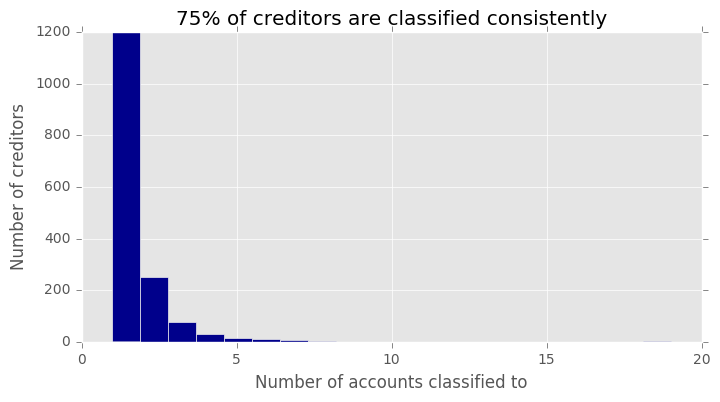

In [141]:
pct_correctly_classed = \
          100 - int(round(multi_accounts_df.shape[0] / float(accounts_df.shape[0]) * 100))

fig = plt.figure (figsize = (8, 4))

ax = fig.add_subplot(1, 1, 1)
ax.hist(accounts_df['# Accounts'], bins = 20, color = 'darkblue')

ax.set_xlabel("Number of accounts classified to")
ax.set_ylabel("Number of creditors")
ax.set_title(str(pct_correctly_classed) + \
             "% of creditors are classified consistently")
plt.show()

#### Creditors Classified to More Than One Account

In [142]:
pd.set_option('display.max_rows', multi_accounts_df.shape[0])
display(multi_accounts_df.reset_index(drop = True))

,Creditor,# Accounts,Account
0,Amazon Uk Marketplace,19,"Books-CDs-Audio-Video, Building Repairs & Maintenance, Cleaning and domestic material, Consumable Catering Supplies, E19 - Learning Resources, E25 - Catering Supplies, Education CFR Administrative S, Education CFR Other Occupation, Equipment and Materials Purcha, Equipment and Materials Repair, Food Costs, General Office Expenses, Hardware Purchases, Miscellaneous Expenses, Other Services, Other Transfer Payments to Soc, Stationery, Training, Travelling Expenses"
1,Amazon Eu,19,"Books-CDs-Audio-Video, Building Repairs & Maintenance, Cleaning and domestic material, E19 - Learning Resources, Education CFR Administrative S, Education CFR Other Occupation, Equipment and Materials Purcha, Equipment and Materials Repair, Grounds maintenance, Miscellaneous Expenses, Other Agencies - Third Party P, Other Services, Other Transfer Payments to Soc, Postage, Professional Services, Publications, Stationery, Training, Travelling Expenses"
2,"Amazon Svcs Europe,Sar",12,"Books-CDs-Audio-Video, Building Repairs & Maintenance, Consumable Catering Supplies, E25 - Catering Supplies, Education CFR Administrative S, Equipment and Materials Purcha, Hardware Purchases, Other Agencies - Third Party P, Other Services, Other Transfer Payments to Soc, Publications, Stationery"
3,Asda Superstore,11,"Building Repairs & Maintenance, Cleaning and domestic material, E19 - Learning Resources, E25 - Catering Supplies, Equipment and Materials Purcha, Food Costs, Other Services, Other Transfer Payments to Soc, Publications, Stationery, Training"
4,Argos Ltd,9,"Books-CDs-Audio-Video, Cleaning and domestic material, E19 - Learning Resources, Equipment and Materials Purcha, Hardware Purchases, Miscellaneous Expenses, Other Agencies - Third Party P, Other Services, Other Transfer Payments to Soc"
5,Post Office Counter,8,"E19 - Learning Resources, Education CFR Administrative S, Miscellaneous Expenses, Other Transfer Payments to Soc, Postage, Stationery, Travelling Expenses, Vehicle Running Costs"
6,Amazon Mktplce Eu-U,8,"Books-CDs-Audio-Video, E19 - Learning Resources, Equipment and Materials Purcha, Food Costs, Other Services, Other Transfer Payments to Soc, Postage, Stationery"
7,Lul Ticket Machine,8,"Books-CDs-Audio-Video, Food Costs, Miscellaneous Expenses, Non Education Staff GPay, Other Agencies - Third Party P, Other Transfer Payments to Soc, Pool Transport Charges, Travelling Expenses"
8,Tesco Store 2467,7,"Cleaning and domestic material, Equipment and Materials Purcha, Food Costs, Other Services, Other Transfer Payments to Soc, Publications, Stationery"
9,Sainsburys S/Mkt,7,"Cleaning and domestic material, Equipment and Materials Purcha, Food Costs, Other Transfer Payments to Soc, Postage, Publications, Stationery"


-----
<a id="groups"></a>

## 5. Grouping Service Areas

After looking at the spending patterns above, we asked if certain service areas were similar in behavior. For this, we considered the number and average of borough transactions. A well-known algorithm for grouping objects is called "k-means clustering". This algorithm locates centers for a given number of groups iteratively, by moving the centers around a graph until the data is partitioned effectively. As a benefit, k-means clustering also returns the data values for each group center. These values are useful for understanding group definitions.

To divide the service areas more finely, we could potentially increase the number of groups used in clustering, at the expense of some 'big picture' intuition. To divide the service areas more roughly, we could decrease the number of groups, at the expense of some precision.

We found four reasonable groups of service areas. The graph below shows these groups. Our goal was to find groups that shared one data attribute (e.g., similar transaction averages), but varied a bit on the other attribute. The groups are as follows:

1. Group 1 has a few, small transactions per service area. Each area shows approximately 90 transactions that average £144 in amount.
2. Group 2 has many, small transactions. The one area in this group shows 5317 transactions that average £66 in amount.
3. Group 3 has a small number of large transactions. Each area shows approximately 46 transactions that average £1756 in amount.
4. Group 4 has a moderate number of small transactions per service area. Each area shows approximately 903 transactions that average £76 in amount.

Below the graph, we list the service areas that compose each group.

In [143]:
## prepare predictors
predictors = np.concatenate((area_counts, area_means), axis = 1)

In [144]:
# create and fit K-means model
n_clusters = 4

model = KMeans(n_clusters = n_clusters)
predict = model.fit_predict(predictors)
cluster_centers = model.cluster_centers_

new_col = np.zeros(data.shape[0]).reshape(-1, 1)
for index in range(num_service_areas):
    area_name = service_areas[index]
    area_indexes = np.where(data['Service Area'] == area_name)
    new_col[area_indexes] = predict[index]
    
new_col_df = pd.DataFrame(new_col, columns = ['Cluster'])
data = pd.concat((data, new_col_df), axis = 1)

In [145]:
# group clusters with service area names
results = np.concatenate((predict.reshape(-1, 1), service_areas.reshape(-1, 1)), axis = 1)
results_df = pd.DataFrame(results, columns = ['Cluster', 'Service Area'])
clusters = results_df.groupby('Cluster')

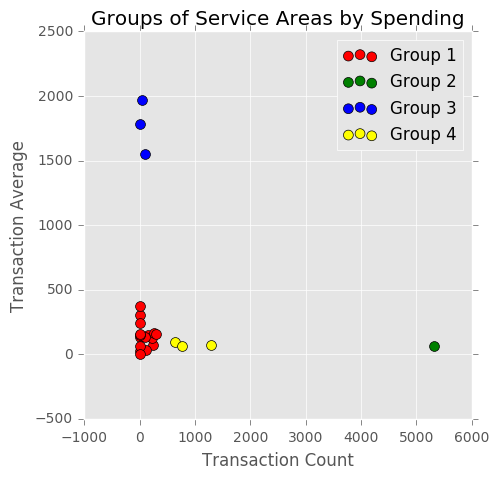

In [146]:
### plot clusters
colors = ['r', 'g', 'b', 'yellow']

fig = plt.figure(figsize = (5, 5))
ax = fig.add_subplot(1, 1, 1)

for cluster in range(n_clusters):
    cluster_counts = area_counts[predict == cluster]
    cluster_means = area_means[predict == cluster]
    ax.scatter(cluster_counts, cluster_means, color = colors[cluster], s = 50,
               edgecolor = 'black', linewidth = 0.5, label = 'Group ' + str(cluster + 1))

ax.set_xlabel("Transaction Count")
ax.set_ylabel("Transaction Average")
ax.set_title("Groups of Service Areas by Spending")
ax.legend(loc = 'best')

plt.show()

### Groups of Service Areas by Spending Behavior

In [147]:
# list clusters
for key, item in clusters:
    print "\tGROUP " + str(key + 1) + \
          "   (Center: Count = " + str(int(cluster_centers[key, 0])) + \
          ", Average = £" + str(int(round(cluster_centers[key, 1]))) + ")"
    print
    
    cluster_df = pd.DataFrame(clusters.get_group(key).iloc[:, 1])
    for area in range(cluster_df.shape[0]):
        print "\t\t" + cluster_df.iloc[area, 0]
    
    print
    print

	GROUP 1   (Center: Count = 90, Average = £144)

		Adults and Communities
		Assurance
		Children's Service DSG
		Commercial
		Commissioning
		Control Accounts
		Corporate Accounting
		Deputy Chief Operating Officer
		Education
		Internal Audit & CAFT
		NSCSO
		Parking & Infrastructure
		Public Health
		Regional Enterprise
		Strategic Commissioning Board
		Street Scene


	GROUP 2   (Center: Count = 5317, Average = £66)

		Children's Family Services


	GROUP 3   (Center: Count = 46, Average = £1767)

		CSG Managed Budget
		Customer Support Group
		Governance


	GROUP 4   (Center: Count = 903, Average = £76)

		Children's Education & Skills
		Childrens Services
		Family Services




-----
<a id="anomalies"></a>

## 6. Anomaly Detection

For anomaly detection we used two approaches, which complemented each other nicely. First, we used a variation of the bell curves that were used to identify spikes and permanent changes above. Second, we considered one-time charges to accounts. Finally, we looked at the intersection of these two approaches.

### Service areas with <= 5 transactions during this time period

We have two caveats:

* First, four of the service areas have fewer than five transactions in this data set. These service areas are listed below and will be omitted from further analysis here. For auditing purposes, it may be practical to investigate all transactions in this small set.
* Second, several service areas have few transactions at the upper end of their bell curves. For these areas, we pulled candidate transactions from lower in the curves.

In [148]:
# find service areas with < 5 transactions in this time period
min_transactions = 5

many_xact_areas = []
few_xact_areas = []

for index in range(num_service_areas):
    area_name = service_areas[index]
    num_xacts = np.count_nonzero(data[data['Service Area'] == area_name]['Total'])
    if num_xacts >= min_transactions:
        many_xact_areas.append((area_name, num_xacts))
    else:
        few_xact_areas.append((area_name, num_xacts))
        
many_xact_areas_df = pd.DataFrame(many_xact_areas, columns = \
                                  ['Service Area', 'Number of Transactions'])
        
few_xact_areas_df = pd.DataFrame(few_xact_areas, columns = \
                                 ['Service Area', 'Number of Transactions'])
display(few_xact_areas_df.reset_index(drop = True))

,Service Area,Number of Transactions
0,Corporate Accounting,4
1,NSCSO,3
2,Public Health,3
3,Strategic Commissioning Board,1


### Frequencies of transaction amounts

To show the range of transaction amounts for each service area and overall, we provide a series of histograms below. For all service areas combined, the spending pattern resembles a bell curve. For individual service areas, spending patterns vary widely.

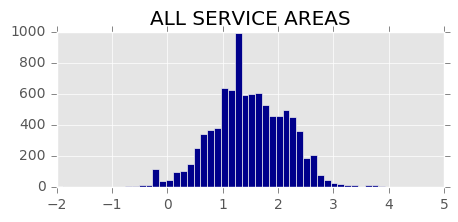

In [149]:
fig, ax = plt.subplots(1, 1, figsize = (5, 2))
ax.hist(np.log10(data[data['Total'] > 0]['Total']), bins = 50, color = 'darkblue')
ax.set_title("All Service Areas".upper())
plt.show()

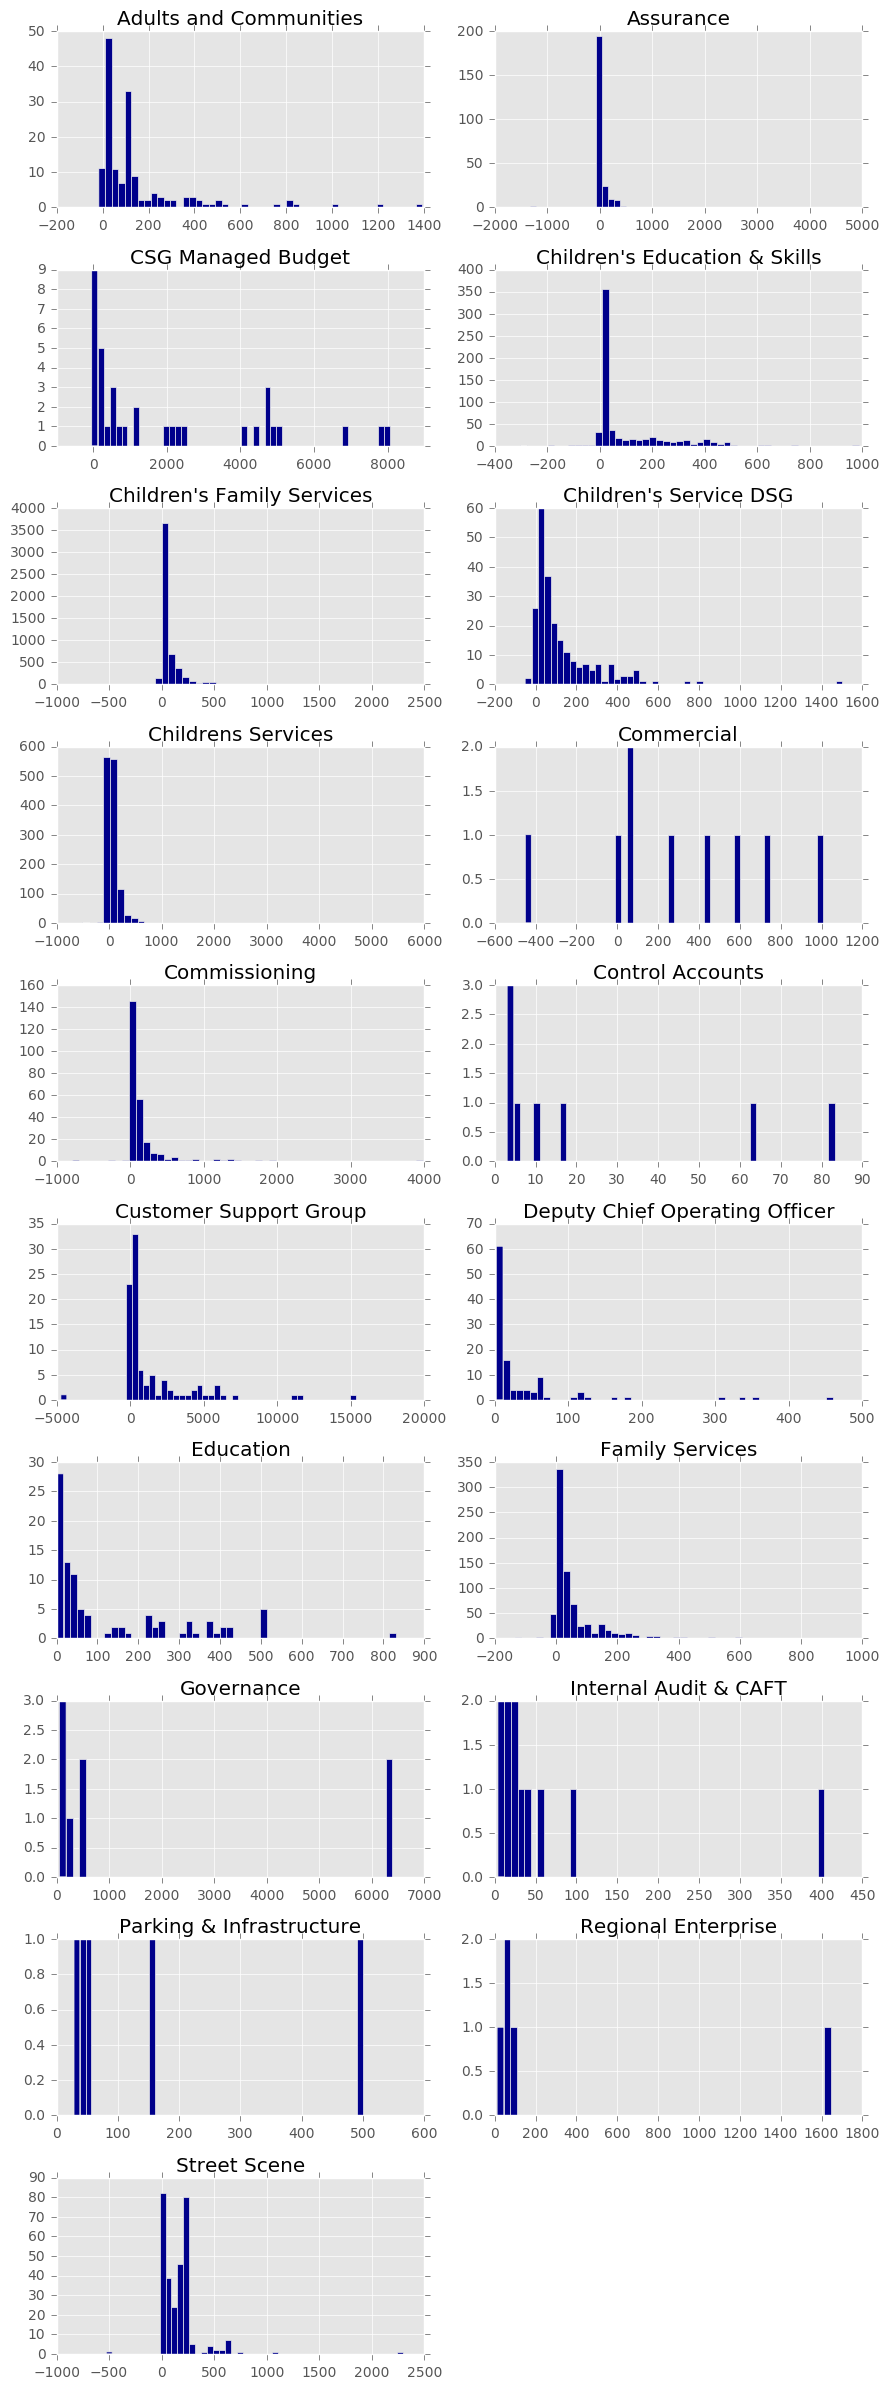

In [150]:
num_areas = many_xact_areas_df.shape[0]
fig, ax_ar = plt.subplots((num_areas / 2) + (num_areas % 2), 2, figsize = (9, 24))

for index in range(num_areas):
    area = many_xact_areas_df.iloc[index, 0]
    area_data = data[data['Service Area'] == area]['Total']
    
    ax_ar[index / 2, index % 2].hist(area_data, bins = 50, color = 'darkblue')
    ax_ar[index / 2, index % 2].set_title(area)

ax_ar[-1, -1].axis('off')
plt.tight_layout()
plt.show()

### Transactions that are anomalous for high transaction amount

A classic approach to anomaly detection is using a bell curve (i.e., normal distribution) to identify outliers. We used a bell curve for the quantitative variable in this data: transaction amount. We set the threshold at the upper 2% of the bell curve, with a curve for each service area. As requested by the auditor, the goal was to identify several hundred candidate anomalies, with a minimum of five candidates from each service area.

Below we list specific anomaly candidates by service area. We found 334 candidates, with at least five candidates per service area. Results are sorted by percentile in each service area, with the highest percentiles being the most apparently anomalous transactions.

To retrieve more candidate anomalies, we could potentially increase the threshold above 2%, at the risk of extra audit work (because of false positives). To retrieve fewer candidate anomalies, we could decrease the threshold below 2%, at the risk of missing real anomalies (because of false negatives). 

In [151]:
### calculate percentiles of transaction amounts for each many-transaction service area

avg_col = np.zeros(num_areas).reshape(-1, 1)
var_col = np.zeros(num_areas).reshape(-1, 1)
percentile_col = np.zeros(data.shape[0])

for index in range(num_areas):
    area_name = many_xact_areas_df.iloc[index, 0]
    area_indexes = np.where(data['Service Area'] == area_name)
    area_totals = data.iloc[area_indexes]['Total'].values
    
    avg_col[index] = area_totals.mean()
    var_col[index] = area_totals.var()
    
    dist = norm(avg_col[index], np.power(var_col[index], 0.5))
    percentile_col[area_indexes] = dist.cdf(data.iloc[area_indexes]['Total'].values)
    
avg_col_df = pd.DataFrame(avg_col, columns = ['Average'])
var_col_df = pd.DataFrame(var_col, columns = ['Variance'])
stat_cols_df = pd.concat((avg_col_df, var_col_df), axis = 1)
many_xact_areas_df = pd.concat((many_xact_areas_df, stat_cols_df), axis = 1)

percentile_col_df = pd.DataFrame(percentile_col.reshape(-1, 1), columns = ['Percentile'])
data = pd.concat((data, percentile_col_df), axis = 1)

In [152]:
pd.options.display.float_format = '{:,.2f}'.format

anomaly_threshold = 0.98
anomalous_data = data[data['Percentile'] > anomaly_threshold]
n, p = anomalous_data.shape
    
for index in range(num_areas):
    area_name = many_xact_areas_df.iloc[index, 0]
    
    area_data = anomalous_data[anomalous_data['Service Area'] == area_name]
    if (area_data.shape[0] >= min_transactions):
        area_data = area_data.sort_values(by = 'Percentile', ascending = False)
        caveat_str = ""
    else:
        extra_transactions = min_transactions - area_data.shape[0]
        caveat_str = "  (" + str(extra_transactions) + \
                        " extra transactions listed to meet analysis requests)"
            
        area_data = data[data['Service Area'] == area_name].sort_values(by = ['Percentile', 'Journal Date'], 
                                                                        ascending = False)
        area_data = area_data.iloc[:min_transactions, :]

    # convert datetimes to date strings for display
    for i in range(area_data.shape[0]):
        area_data['Journal Date'].values[i] = area_data['Journal Date'].values[i].strftime("%Y-%b-%d")
      
    #convert percentiles to integers for display
    area_data['Percentile'] = (area_data['Percentile'] * 100.0).round().astype(int)
    
    print
    print area_name.upper() + caveat_str
    display(area_data[['Account', 'Creditor', 'Journal Date', 'Journal Reference', 'Total', 
                                      'Percentile']].reset_index(drop = True).reset_index(drop = True))

print anomalous_data.shape[0]


ADULTS AND COMMUNITIES


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Publications,Guardian News & Media,2015-Dec-04,6273,"1,391.04",100
1,Training,Www.Adass.Org.Uk,2016-May-30,8210,"1,200.00",100
2,Private Contractors - Third Pa,Saracens Ltd,2015-Jan-07,4766,"1,000.00",100
3,Subsistence,Holiday Inn Wembley,2014-Jul-31,1579,840.00,100
4,Subsistence,Premier Inn,2014-Apr-30,289,815.50,100
5,Subsistence,Premier Inn,2014-Apr-30,290,815.50,100
6,Training,Premier Inn,2015-Oct-14,5623,754.00,100
7,Training,The Adult Learning,2016-May-25,8173,620.00,98



ASSURANCE  (1 extra transactions listed to meet analysis requests)


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Venue Hire,Alexandra Palace,2016-May-02,7960,"4,342.20",100
1,Equipment Hire,Marquee Carpets Limite,2016-Jun-30,8598,"1,315.20",100
2,General Office Expenses,Www.Clothes2Order.C,2015-May-21,5729,"1,276.92",100
3,Miscellaneous Expenses,Clothes 2 Order,2016-Jun-06,8284,880.50,99
4,Stationery,Sna Manufacturing Ltd,2015-Sep-29,5477,660.50,97



CSG MANAGED BUDGET  (3 extra transactions listed to meet analysis requests)


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Legal and Court Fees,Hmcourts-Service.G,2014-Sep-23,2235,"8,058.00",99
1,Legal and Court Fees,Hmcourts-Service.G,2014-May-22,498,"7,800.00",99
2,Legal and Court Fees,Hmcourts-Service.G,2014-May-22,497,"6,777.00",98
3,Legal and Court Fees,Hmcourts-Service.G,2014-Aug-19,1914,"4,998.00",90
4,Legal and Court Fees,Hmcourts-Service.G,2014-Jun-17,1245,"4,977.00",89



CHILDREN'S EDUCATION & SKILLS


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Training,Pentagon,2015-Jun-18,4344,987.47,100
1,Books-CDs-Audio-Video,Sp Down Syndrome E,2015-Feb-10,5101,730.44,100
2,Food Costs,Compass Services Uk,2014-Nov-28,3530,648.00,100
3,Travelling Expenses,Lbbarnet Payenet,2015-Jan-16,4633,610.80,100
4,Equipment and Materials Purcha,Ce-Ces Ltd,2015-Jan-13,4393,500.00,100
5,Equipment and Materials Repair,Afe Serviceline,2015-Apr-30,3033,500.00,100
6,Equipment and Materials Purcha,Dawsonsdepartments,2015-Aug-24,5114,495.00,100
7,Food Costs,Kays Delicatessen,2015-Dec-15,6407,489.70,100
8,Food Costs,Kays Delicatessen,2015-Dec-16,6422,489.70,100
9,Food Costs,Kays Delicatessen,2016-Jan-06,6588,485.91,100



CHILDREN'S FAMILY SERVICES


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Other Agencies - Third Party P,Www.Ilxgroup.Com,2015-Dec-02,6242,"1,954.80",100
1,Equipment and Materials Purcha,Access Expeditions,2016-Jul-11,8696,"1,604.76",100
2,Other Agencies - Third Party P,South Mimms Travel,2015-Jul-23,4771,"2,262.91",100
3,Gas,British Gas Busine,2016-Jun-30,8600,"1,695.22",100
4,Miscellaneous Expenses,Austin David Ltd,2016-Apr-22,7870,"1,595.47",100
5,Other Transfer Payments to Soc,Argos B2B Online,2015-May-28,3249,"1,240.86",100
6,Miscellaneous Expenses,Carpet Time,2016-Apr-29,7942,"1,492.00",100
7,Miscellaneous Expenses,Argos B2B Online,2015-May-28,3248,"1,107.56",100
8,Other Transfer Payments to Soc,Dans Carpet And Floori,2016-May-12,8047,"1,034.00",100
9,Miscellaneous Expenses,Premier Inn,2015-May-11,3092,"1,000.00",100



CHILDREN'S SERVICE DSG


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Subscriptions,Mk Language Centre,2016-Aug-08,9037,"1,500.00",100
1,Equipment and Materials Purcha,Www.Posturite.Co.Uk,2016-Apr-11,7719,788.34,100
2,Equipment and Materials Purcha,Hp Inc Uk Limited,2015-Dec-18,6444,749.17,100
3,Training,Payatrader,2015-May-28,3250,584.00,100
4,Training,Payatrader,2015-Jan-08,4810,520.00,99
5,Books-CDs-Audio-Video,Books Education,2016-Mar-02,7307,506.47,99
6,Books-CDs-Audio-Video,Wp-The British Ass,2014-Dec-11,4279,500.00,99
7,Professional Services,Inpp Ltd,2016-Feb-26,7240,500.00,99
8,Professional Services,Inpp Ltd,2016-Feb-26,7242,500.00,99
9,Equipment and Materials Purcha,Aa Media,2015-Oct-23,5731,480.00,98



CHILDRENS SERVICES


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Other Services,Access Expeditions,2014-Apr-03,111,"6,000.00",100
1,Travelling Expenses,Currie Motors Car,2014-May-23,391,"1,960.00",100
2,Miscellaneous Expenses,Hertsmere Borough,2014-Jul-03,1256,"2,439.16",100
3,Legal and Court Fees,Council Tax,2014-Jun-16,942,"1,406.50",100
4,Other Services,Motorsport World Lt,2014-Aug-01,1415,983.40,100
5,Books-CDs-Audio-Video,Pearson Ed Ltd,2014-May-05,477,855.50,100
6,Equipment and Materials Purcha,Chubb Electronic Se,2014-May-08,786,686.64,100
7,Other Services,Parkholidays.Com,2014-Jul-31,1279,605.00,99
8,Books-CDs-Audio-Video,Granada Learning,2014-May-05,474,600.42,99
9,Private Contractors - Third Pa,Chicken Shed Theatr,2014-Apr-17,194,600.00,99



COMMERCIAL  (5 extra transactions listed to meet analysis requests)


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Private Contractors - Third Pa,Www.Telecare.Org.Uk,2014-Aug-25,1898,"1,008.00",96
1,Private Contractors - Third Pa,Www.Fridgeland.Co.U,2014-Aug-22,1897,717.35,84
2,Subscriptions,Solace Ltd,2014-Aug-18,1895,594.00,76
3,Private Contractors - Third Pa,Eb Local Authoritie,2014-Sep-08,2222,450.00,64
4,Equipment and Materials Purcha,British Gas Tradin,2014-Aug-18,1896,262.75,46



COMMISSIONING


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Furniture-Purchase-Repair,Www.Officefurnitureonl,2015-Oct-02,5525,"3,984.00",100
1,Training,Www.Advantagelearning.,2016-Jun-16,8403,"1,910.40",100
2,Building Repairs & Maintenance,Met Parking Services L,2015-Jun-02,3298,"1,740.00",100
3,Training,The Coaching Academy,2016-Aug-18,9144,"1,500.00",100
4,Professional Services,Reedmidem.Com,2015-Feb-19,5202,"1,335.16",100
5,Professional Services,Reedmidem.Com,2015-Feb-23,5204,"1,326.62",100
6,Training,Continuity Shop,2015-Jul-24,4778,"1,310.00",100
7,Counsels Fees,Hemsley Fraser Group L,2016-Feb-26,7238,"1,200.00",100
8,Conference Expenses,Redactive,2016-Mar-18,7506,"1,128.00",100



CONTROL ACCOUNTS  (5 extra transactions listed to meet analysis requests)


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Other Transfer Payments to Soc,Amazon *Mktplce Eu-,2014-Apr-07,101,83.31,98
1,Miscellaneous Expenses,Argos Retail Group,2014-Jun-13,1019,63.94,91
2,Other Transfer Payments to Soc,Amazon *Mktplce Eu-,2014-Apr-03,97,15.99,39
3,Other Transfer Payments to Soc,Amazon *Mktplce Eu-,2014-Apr-03,96,10.99,33
4,Other Transfer Payments to Soc,Amazon *Mktplce Eu-,2014-Apr-04,98,5.28,26



CUSTOMER SUPPORT GROUP  (2 extra transactions listed to meet analysis requests)


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Fees and Charges,Hmcourts-Service.G,2015-May-20,3161,"15,340.80",100
1,Legal and Court Fees,Hmcourts-Service.G,2016-Jun-23,8504,"11,487.00",100
2,Legal and Court Fees,Hmcourts-Service.G,2016-May-26,8190,"11,088.00",100
3,Fees and Charges,Hmcourts-Service.G,2015-Jul-21,4722,"6,955.20",97
4,Legal and Court Fees,Hmcourts-Service.G0,2015-May-21,5842,"6,207.00",95



DEPUTY CHIEF OPERATING OFFICER  (1 extra transactions listed to meet analysis requests)


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Travelling Expenses,Eurostar Internatio,2014-Oct-10,3289,460.00,100
1,Training,Www.Westminster-Bri,2014-Apr-02,189,354.00,100
2,Grounds maintenance,Pinks Spires,2014-Jun-03,1026,340.00,100
3,Equipment and Materials Purcha,Inspired Frames,2014-Jul-11,1347,312.50,100
4,Equipment and Materials Purcha,Inspired Frames,2014-Jul-11,1348,182.50,98



EDUCATION


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Books-CDs-Audio-Video,Pearson Ed Ltd,2014-Sep-25,2244,830.10,100
1,Equipment and Materials Purcha,Ce-Ces Ltd,2014-Aug-12,1629,500.00,98
2,Private Contractors - Third Pa,Ce-Ces Ltd,2014-Sep-23,2098,500.00,98
3,Equipment and Materials Purcha,Ce-Ces Ltd,2014-Sep-03,1957,500.00,98
4,Equipment and Materials Purcha,Ce-Ces Ltd,2014-Oct-21,3124,500.00,98
5,Equipment and Materials Purcha,Majestic Wine,2014-Oct-03,3131,500.00,98



FAMILY SERVICES


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Miscellaneous Expenses,Equita Ltd,2014-Aug-27,1714,989.29,100
1,Equipment and Materials Purcha,Tesco Direct,2014-Sep-19,2213,914.00,100
2,Other Transfer Payments to Soc,Argos Direct,2014-Oct-16,3489,890.95,100
3,Private Contractors - Third Pa,Ticketmaster Uk,2014-Oct-27,3365,850.00,100
4,Other Services,Mapyxlimite,2014-Aug-22,1794,695.40,100
5,Equipment and Materials Purcha,Carpet Time,2014-Oct-03,3285,610.00,100
6,Building Repairs & Maintenance,Carpetright,2014-Aug-27,1744,594.44,100
7,Building Repairs & Maintenance,Carpetright,2014-Sep-01,1745,594.44,100
8,Miscellaneous Expenses,Reventus Limited,2014-Oct-17,3514,589.85,100
9,Training,Skills Training,2014-Sep-25,2260,576.00,100



GOVERNANCE  (5 extra transactions listed to meet analysis requests)


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Other Services,Better Life Health,2014-Apr-24,286,"6,388.20",96
1,Other Services,Better Life Health,2014-Apr-24,287,"6,388.20",96
2,Stationery,Www.Cartridgesave.C,2014-Sep-12,2153,480.03,31
3,Stationery,Www.Cartridgesave.C,2014-Sep-24,2155,444.93,31
4,Professional Services,Westminster Forum,2014-Jul-01,1198,252.00,28



INTERNAL AUDIT & CAFT  (4 extra transactions listed to meet analysis requests)


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Equipment and Materials Purcha,Canford Audio Plc,2014-Jun-19,1195,403.20,100
1,Private Contractors - Third Pa,Eb Tenancy Fraud Fo,2014-Oct-30,3504,99.00,62
2,Equipment and Materials Purcha,D H C Ltd,2014-Aug-04,1931,56.07,47
3,Equipment and Materials Purcha,D H C Ltd,2014-Jul-25,1617,37.08,40
4,Legal and Court Fees,Barnet Register Off,2014-Jul-14,1417,30.00,37



PARKING & INFRASTRUCTURE  (5 extra transactions listed to meet analysis requests)


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Miscellaneous Expenses,Nochex. Bph Postcodes,2016-Jun-15,8392,500.00,97
1,Equipment and Materials Purcha,Amazon Eu,2015-Oct-01,5497,159.67,51
2,Books-CDs-Audio-Video,Amazon Mktplce Eu-U,2014-Nov-25,3541,51.02,28
3,Equipment and Materials Purcha,Amazon Eu,2014-Nov-06,3531,41.80,26
4,Equipment and Materials Purcha,Amazon Uk Retail,2015-Feb-06,4827,28.43,24



REGIONAL ENTERPRISE  (5 extra transactions listed to meet analysis requests)


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Professional Services,J W Ruddock &Sons Ltd,2015-Dec-01,6227,"1,645.00",98
1,Training,Public Sector Connect,2016-Jul-19,8692,100.00,33
2,Consultants Fees,Www.Companywatch.Net,2016-Mar-14,7443,60.00,31
3,Equipment and Materials Purcha,Www.Companywatch.Ne,2015-Jan-22,4502,60.00,31
4,Subscriptions,Companies House,2016-Aug-11,9079,12.00,28



STREET SCENE


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Advertising,Haymarket Publishi,2015-Aug-12,4980,"2,295.60",100
1,Equipment and Materials Purcha,Direct 365Online Ltd,2015-Oct-01,5508,"1,098.00",100
2,Other Services,British Standards,2015-Feb-16,5200,717.95,100
3,Vehicle Running Costs,Www.Dvla.Gov.Uk,2015-Jul-13,4629,652.50,99
4,Vehicle Running Costs,Www.Dvla.Gov.Uk,2015-Jun-22,4368,652.50,99
5,Vehicle Running Costs,Www.Dvla.Gov.Uk,2015-May-25,3200,652.50,99
6,Vehicle Running Costs,Dvla Vehicle Tax,2016-May-25,8172,652.50,99
7,Vehicle Running Costs,Www.Dvla.Gov.Uk,2016-Mar-21,7522,652.50,99
8,Vehicle Running Costs,Dvla Vehicle Tax,2016-Jun-21,8446,652.50,99
9,Vehicle Running Costs,Dvla Vehicle Tax,2016-Jun-21,8449,652.50,99


334


### One-time charges to an account by a service area

In addition to considering bell-curve anomalies, we also looked at cases where an account was charged only once by a specific service area. Such a charge potentially represented either misclassification or misconduct. Tabulation and filtering gave the results below, which show 91 transactions that were one-time account charges by a service area.

To retrieve more candidate anomalies, we could potentially increase the threshold above one-time account use per service area, at the risk of extra audit labor (because of false positives). 

In [153]:
### find one-time charges to an account by a service area (anomaly or misclassification?)

singles_accum = 0
large_singletons_accum = pd.DataFrame()

for index in range(num_areas):
    area_name = many_xact_areas_df.iloc[index, 0]
    area_indexes = np.where(data['Service Area'] == area_name)
    area_data = data.iloc[area_indexes]
    
    count_accounts = Counter(area_data['Account'])
    once_accounts = { key for key, value in count_accounts.iteritems() if value == 1}
    num_once_accounts = len(once_accounts)
    if num_once_accounts > 0:
        singles_accum += num_once_accounts
        singletons_df = area_data[area_data['Account'].isin(once_accounts)].copy()
        large_singletons_df = singletons_df[singletons_df['Percentile'] >= 0.98 ]
        large_singletons_accum = pd.concat((large_singletons_accum, large_singletons_df), 
                                           axis = 0)
        
        # convert datetimes to date strings for display
        for i in range(singletons_df.shape[0]):
            singletons_df['Journal Date'].values[i] = singletons_df['Journal Date'].values[i].strftime("%Y-%b-%d")
    
        #convert percentiles to integers for display
        singletons_df['Percentile'] = (singletons_df['Percentile'] * 100.0).round().astype(int)
        
        print
        print area_name.upper()
        display(singletons_df[['Account', 'Creditor', 'Journal Date', 'Journal Reference', 'Total', 
            'Percentile']].sort_values(by = 'Percentile', ascending = False).reset_index(drop = True))

print singles_accum


ADULTS AND COMMUNITIES


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Private Contractors - Third Pa,Saracens Ltd,2015-Jan-07,4766,"1,000.00",100
1,Publications,Guardian News & Media,2015-Dec-04,6273,"1,391.04",100
2,Other Vehicle Costs,Lbbarnet Payenet,2014-Sep-04,2220,534.45,96
3,Subscriptions,Paypal Localinform0,2015-May-21,5753,210.00,60
4,Building Repairs & Maintenance,Www.Audiomate.Co.Uk,2015-Feb-09,5032,163.80,52
5,Legal and Court Fees,Gro Hm Passport Off,2015-Jan-13,4767,23.40,28
6,General Office Expenses,Land Registry,2016-May-18,8102,16.80,27



ASSURANCE


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Venue Hire,Alexandra Palace,2016-May-02,7960,"4,342.20",100
1,Equipment Hire,Marquee Carpets Limite,2016-Jun-30,8598,"1,315.20",100
2,Other Services,Golden Boy Coaches,2015-May-19,3145,448.00,88
3,Grounds maintenance,Pinks Spires0000000,2015-May-21,5716,340.00,80
4,Transport Hire Charges,Hearns Coaches,2016-Jun-20,8439,306.00,77
5,Conference Expenses,Blackpool Hilton,2015-Oct-01,5506,170.00,62
6,Professional Services,Www.192.Com,2014-Nov-06,3711,89.94,52
7,Books-CDs-Audio-Video,Amazon Svcs Europes,2015-Jan-29,4789,27.90,45
8,Legal and Court Fees,Lbb Civic Centre Pa,2014-Nov-13,3928,4.00,42
9,Fixtures and fittings,Marquee Carpets Limitewaltham Cross,2016-Aug-19,9175,"-1,315.20",0



CSG MANAGED BUDGET


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Equipment and Materials Purcha,Www.Clothes2Order.C,2014-May-09,806,"1,237.68",38
1,Other Services,Mr Box Ltd,2014-May-05,805,598.80,28
2,Private Contractors - Third Pa,Am.Uk Xing For Lat,2014-May-09,807,274.80,24
3,IT Services,Surveymonkey.Com,2014-Jun-05,1193,299.00,24
4,Professional Services,Iia - Uk Ireland,2014-Jul-29,1578,173.00,23



CHILDREN'S EDUCATION & SKILLS


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Professional Services,Westminster Forum,2015-Dec-02,6245,166.67,69
1,Transport Hire Charges,North London Bus.,2015-Jun-17,4319,36.00,34
2,Clothing - Protective Clothing,Homebase Ltd 588,2015-Dec-23,6531,19.89,30
3,Employer's National Insurance,Govknow Events Limited,2015-Nov-12,5990,6.67,26



CHILDREN'S FAMILY SERVICES


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Advertising,Funding Solutions For,2015-Sep-11,5292,660.00,100
1,Gas,British Gas Busine,2016-Jun-30,8600,"1,695.22",100
2,Advertising for staff,Reed Online Limited (E,2016-Apr-20,7829,450.00,100



CHILDREN'S SERVICE DSG


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,General Office Expenses,Www.Icetrak.Com,2015-Jan-06,4771,60.00,34
1,Stationery,Staples Uk,2014-Aug-05,1913,14.06,25



CHILDRENS SERVICES


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Transport Hire Charges,Currie Motors Car,2014-Jun-20,943,365.00,91
1,Professional Services,Paypal Jimwild,2014-May-19,479,200.00,73
2,General Office Expenses,Www.Icetrak.Com,2014-Jun-19,1244,120.00,59
3,Clothing - Protective Clothing,Www.Tibard.Co.Uk,2014-May-14,415,97.14,55



COMMERCIAL


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Subscriptions,Solace Ltd,2014-Aug-18,1895,594.00,76
1,Equipment and Materials Purcha,British Gas Tradin,2014-Aug-18,1896,262.75,46
2,Travelling Expenses,Trainline.Com,2014-Sep-05,2221,73.95,29
3,Telephone Rentals,Vodafone,2014-Sep-26,2224,72.00,29
4,Legal and Court Fees,Ccbcoffice,2014-Aug-05,1728,15.00,24



COMMISSIONING


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Counsels Fees,Hemsley Fraser Group L,2016-Feb-26,7238,"1,200.00",100
1,Building Repairs & Maintenance,Met Parking Services L,2015-Jun-02,3298,"1,740.00",100
2,Furniture-Purchase-Repair,Www.Officefurnitureonl,2015-Oct-02,5525,"3,984.00",100
3,Consultants Fees,Surveymonkey.Com,2016-May-25,8179,900.00,98
4,Other Transfer Payments to Soc,Cilex Law School Limit,2015-Nov-03,5855,282.50,63
5,E19 - Learning Resources,Westminster Forum,2015-Jul-07,4571,252.00,60
6,Grounds maintenance,The Pink Flower Gro,2014-Nov-20,3647,160.99,50
7,Private Contractors - Third Pa,Ppsecuritydir,2014-Dec-03,4235,157.20,50
8,Catering Recharge,The Emergency Plan,2016-Mar-09,7386,100.00,43
9,Legal and Court Fees,Tfl Penalty Charge,2014-Nov-27,3648,65.00,40



CONTROL ACCOUNTS


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Miscellaneous Expenses,Argos Retail Group,2014-Jun-13,1019,63.94,91



CUSTOMER SUPPORT GROUP


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Private Contractors - Third Pa,Hertsmere Borough,2015-Feb-12,5199,"2,034.00",57
1,Stationery,Office Depot,2016-Apr-19,7823,794.70,39
2,Grounds maintenance,Treecare,2014-Dec-17,4311,500.00,35
3,Miscellaneous Expenses,Paypal Workerswork,2015-Aug-27,5143,181.80,31
4,Telephone Rentals,Vodafone Ltd,2016-May-18,8107,196.08,31
5,IT Services,Www.Zatpay.Com,2015-Jan-08,4764,60.00,30
6,Professional Services,Able Group Uk,2015-Jun-11,4240,114.00,30
7,Postage,Interlink Express,2014-Dec-11,4310,22.79,29
8,Advertising,Sna Manufacturing L,2014-Dec-17,4312,19.78,29



DEPUTY CHIEF OPERATING OFFICER


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Training,Www.Westminster-Bri,2014-Apr-02,189,354.00,100
1,Grounds maintenance,Pinks Spires,2014-Jun-03,1026,340.00,100
2,Private Contractors - Third Pa,David Lloyd,2014-Sep-18,2076,4.45,33



EDUCATION


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Subscriptions,Paypal Clpe,2014-Oct-10,3470,308.00,85
1,Cleaning and domestic material,Firstchoice Caterin,2014-Sep-01,1634,246.90,75
2,Venue Hire,North London Bus.,2014-Sep-03,2243,63.00,34
3,Grounds maintenance,The Urban Flower Co,2014-Sep-30,2102,50.00,31
4,Subsistence,Hendon Bagel Bakery,2014-Sep-02,2084,25.75,26
5,Building Repairs & Maintenance,Homebase Ltd 588,2014-Oct-13,3312,13.28,24



FAMILY SERVICES


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Hardware Purchases,Argos Ltd,2014-Oct-13,3355,42.74,43
1,Advertising,Www.Feedaread.Com,2014-Sep-12,2009,38.44,42
2,Consumable Catering Supplies,Q Stores,2014-Oct-24,3256,30.86,39
3,Equipment and Materials Repair,Bartletts Key Servi,2014-Sep-10,2032,28.29,38
4,Clothing - Protective Clothing,Alexandra,2014-Aug-13,1859,11.60,33
5,General Office Expenses,Registration Contac,2014-Sep-11,2152,10.00,32



GOVERNANCE


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Professional Services,Westminster Forum,2014-Jul-01,1198,252.00,28
1,Building Repairs & Maintenance,Screwfix Direct,2014-Jun-24,1196,75.20,26



INTERNAL AUDIT & CAFT


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Private Contractors - Third Pa,Eb Tenancy Fraud Fo,2014-Oct-30,3504,99.00,62



PARKING & INFRASTRUCTURE


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Miscellaneous Expenses,Nochex. Bph Postcodes,2016-Jun-15,8392,500.00,97
1,Books-CDs-Audio-Video,Amazon Mktplce Eu-U,2014-Nov-25,3541,51.02,28



REGIONAL ENTERPRISE


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Professional Services,J W Ruddock &Sons Ltd,2015-Dec-01,6227,"1,645.00",98
1,Training,Public Sector Connect,2016-Jul-19,8692,100.00,33
2,Equipment and Materials Purcha,Www.Companywatch.Ne,2015-Jan-22,4502,60.00,31
3,Consultants Fees,Www.Companywatch.Net,2016-Mar-14,7443,60.00,31
4,Subscriptions,Companies House,2016-Aug-11,9079,12.00,28



STREET SCENE


,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Other Services,British Standards,2015-Feb-16,5200,717.95,100
1,Postage,Post Office Counter,2015-Feb-02,4797,565.00,98
2,Stationery,Qubic Print Direct,2015-Feb-10,5236,294.78,75
3,Operating Leases - Transport,Bowmonk Ltd,2016-Feb-25,7213,65.83,32


91


### Transactions with large amounts and one-time account charges

A small number of transactions showed both large amounts and one-time account charges. Such transactions were doubly anomalous and therefore good candidates for auditing. We list the results below, using the same thresholds as above. 14 transactions show both large amounts and one-time account charges.

In [154]:
#convert percentiles to integers for display
large_singletons_accum['Percentile'] = \
                (large_singletons_accum['Percentile'] * 100.0).round().astype(int)
        

display(large_singletons_accum[['Account', 'Creditor', 'Journal Date', 'Journal Reference',
                                'Total', 'Percentile']].sort_values(by = 'Percentile', 
                                                        ascending = False).reset_index(drop = True))

,Account,Creditor,Journal Date,Journal Reference,Total,Percentile
0,Private Contractors - Third Pa,Saracens Ltd,2015-01-07 00:00:00,4766,"1,000.00",100
1,Publications,Guardian News & Media,2015-12-04 00:00:00,6273,"1,391.04",100
2,Venue Hire,Alexandra Palace,2016-05-02 00:00:00,7960,"4,342.20",100
3,Equipment Hire,Marquee Carpets Limite,2016-06-30 00:00:00,8598,"1,315.20",100
4,Advertising,Funding Solutions For,2015-09-11 00:00:00,5292,660.00,100
5,Gas,British Gas Busine,2016-06-30 00:00:00,8600,"1,695.22",100
6,Advertising for staff,Reed Online Limited (E,2016-04-20 00:00:00,7829,450.00,100
7,Counsels Fees,Hemsley Fraser Group L,2016-02-26 00:00:00,7238,"1,200.00",100
8,Building Repairs & Maintenance,Met Parking Services L,2015-06-02 00:00:00,3298,"1,740.00",100
9,Furniture-Purchase-Repair,Www.Officefurnitureonl,2015-10-02 00:00:00,5525,"3,984.00",100
